In [2]:
# import packages and read in full dataset (pca features)
from read_data import get_all_data, split_and_stratify_data, get_balanced_df

import warnings
warnings.filterwarnings('ignore') # for looks..

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, log_loss, matthews_corrcoef
import scikitplot as skplt

full_dataset = get_all_data(number_of_pca_features = 100)
full_dataset.head()

GroundTruth.csv read. Processing/searching for image data. May take a few minutes if process_images_again == True.

Existing image data read..
Here is the cumulative variance explained by the top n principal components..
[0.31257716 0.54008686 0.66481299 0.7057795  0.74346465 0.77956174
 0.80114615 0.81924822 0.83539777 0.8507423  0.86424108 0.8750329
 0.88251965 0.88884104 0.89510091 0.90050337 0.90577069 0.91083161
 0.91540637 0.91968503 0.92259132 0.92535737 0.92803304 0.93063927
 0.93311294 0.93549835 0.93778653 0.93980628 0.94179666 0.94344428
 0.94486636 0.94619368 0.94750187 0.94877141 0.95000678 0.95122232
 0.95237959 0.9534572  0.95452557 0.95557189 0.95661161 0.95758342
 0.95852778 0.95936875 0.96019455 0.96099447 0.96176479 0.96252313
 0.96324924 0.9639561  0.96464723 0.96529059 0.96592324 0.9665458
 0.96711326 0.96765529 0.96819545 0.96870674 0.96921178 0.96970669
 0.97018163 0.97064448 0.97110586 0.97154421 0.971972   0.97238688
 0.97279964 0.97319277 0.97357719 0.97395033

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: cancer_type, dtype: int64

In [3]:
# split into train test and validation datasets
train, test, validate = split_and_stratify_data(full_dataset, random = 1)

# balance the training set?
#train = get_balanced_df(train, val_size = 1000, col = 'cancer_type')

# create X and y train, test and validate sets
X_train = train.iloc[:,2:-1]
X_test = test.iloc[:,2:-1]
X_validate = validate.iloc[:,2:-1]

y_train = train.iloc[:,1]
y_test = test.iloc[:,1]
y_validate = validate.iloc[:,1]

# over samples the under-represented classes - seems to have improved random forest, maybe svm a little, hurt all other models
sm = SMOTE(random_state=2)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print('Training Set Cancer Counts')
print(y_train.value_counts())
print('Test Set Cancer Counts')
print(y_test.value_counts())
print('Validation Set Cancer Counts')
print(y_validate.value_counts())

Training Set Cancer Counts
NV       5364
MEL       890
BKL       879
BCC       411
AKIEC     262
VASC      114
DF         92
Name: cancer_type, dtype: int64
Test Set Cancer Counts
NV       670
MEL      111
BKL      110
BCC       51
AKIEC     33
VASC      14
DF        12
Name: cancer_type, dtype: int64
Validation Set Cancer Counts
NV       671
MEL      112
BKL      110
BCC       52
AKIEC     32
VASC      14
DF        11
Name: cancer_type, dtype: int64


In [4]:
# function for evaluating a classification model

def evaluate_model(model, y_test, X_test):

    y_pred = model.predict(X_test)
    y_probas = model.predict_proba(X_test)

    print(f'Model Accuracy is {round(accuracy_score(y_test, y_pred),4)*100}%')
    print(f'Log loss of the model is {round(log_loss(y_test, y_probas), 3)}')
    print(f'Matthews Correlation Coefficient is {round(matthews_corrcoef(y_test, y_pred),3)}')
    print('\nHere is the classification report. \n')
    print(classification_report(y_test, y_pred))

    print('Confusion Matrix is here:\n')
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show() 

    print('Here are the ROC Curves: \n')
    skplt.metrics.plot_roc_curve(y_test, y_probas)
    plt.show()
    

# Random Forest Classifier

Model Accuracy is 68.33%
Log loss of the model is 0.823
Matthews Correlation Coefficient is 0.182

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.00      0.00      0.00        33
         BCC       1.00      0.06      0.11        51
         BKL       0.42      0.05      0.08       110
          DF       0.00      0.00      0.00        12
         MEL       0.56      0.13      0.21       111
          NV       0.69      0.99      0.81       670
        VASC       1.00      0.07      0.13        14

    accuracy                           0.68      1001
   macro avg       0.52      0.18      0.19      1001
weighted avg       0.63      0.68      0.58      1001

Confusion Matrix is here:



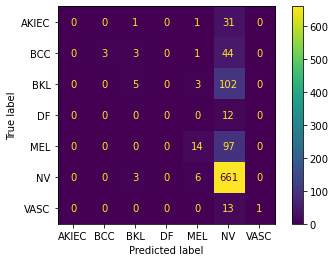

Here are the ROC Curves: 



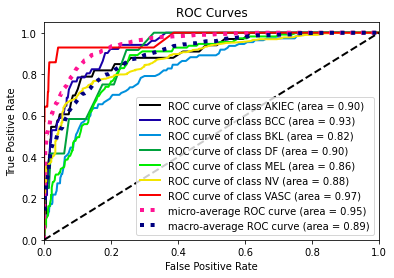

In [11]:
from sklearn.ensemble import RandomForestClassifier

'''
forest_parameters = {'n_estimators': [50,100,200,500], 'max_depth': [3, 5, 10, None], 'class_weight': ['balanced', None]}
clf = RandomForestClassifier(random_state=42)
forest_clf = GridSearchCV(clf, forest_parameters, scoring = 'neg_log_loss', n_jobs=-1)
forest_clf.fit(X_train, y_train)
print(forest_clf.best_params_)
forest_clf = forest_clf.best_estimator_
'''

forest_clf = RandomForestClassifier(n_estimators=500)
forest_clf.fit(X_train, y_train)

evaluate_model(model = forest_clf, y_test = y_test, X_test = X_test)

Hyperparameter tuning over this list of parameters {'n_estimators': [50,100,200,500], 'max_depth': [3, 5, 10, None], 'class_weight': ['balanced', None]} resulted in the best parameters being {'class_weight': None, 'max_depth': None, 'n_estimators': 500}. Performance is still not great. Improving the model at this point would require different sampling of initial training dataset, I think..

#  Gaussian Naive Bayes

Model Accuracy is 67.23%
Log loss of the model is 0.976
Matthews Correlation Coefficient is 0.085

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.00      0.00      0.00        33
         BCC       0.80      0.08      0.14        51
         BKL       0.33      0.01      0.02       110
          DF       0.00      0.00      0.00        12
         MEL       0.00      0.00      0.00       111
          NV       0.67      1.00      0.80       670
        VASC       0.00      0.00      0.00        14

    accuracy                           0.67      1001
   macro avg       0.26      0.15      0.14      1001
weighted avg       0.53      0.67      0.55      1001

Confusion Matrix is here:



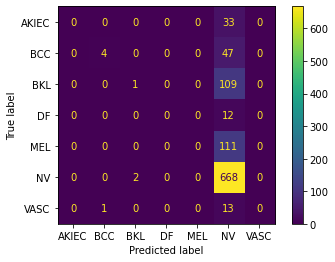

Here are the ROC Curves: 



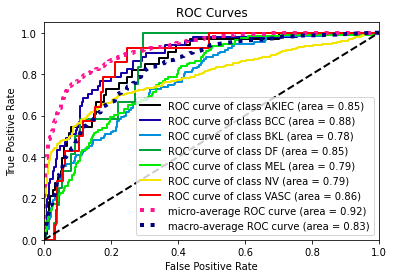

In [7]:
from sklearn.naive_bayes import GaussianNB

'''
gaussian_parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
clf = GaussianNB()
gaussian_clf = GridSearchCV(clf, gaussian_parameters, scoring = 'neg_log_loss', n_jobs=-1)
gaussian_clf.fit(X_train, y_train)
print(gaussian_clf.best_params_)
gaussian_clf = gaussian_clf.best_estimator_
'''

gaussian_clf = GaussianNB(var_smoothing = 0.1873817422860384)
gaussian_clf.fit(X_train, y_train)


evaluate_model(model = gaussian_clf, y_test = y_test, X_test = X_test)

Hyperparameter tuning over space of {'var_smoothing': np.logspace(0,-9, num=100)} resulting in var_smoothing = 0.1873817422860384.. Based on metrics, model appears to be somewhat worse than random forest.

# Logistic Regression

Model Accuracy is 70.23%
Log loss of the model is 0.814
Matthews Correlation Coefficient is 0.335

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.11      0.03      0.05        33
         BCC       0.53      0.41      0.46        51
         BKL       0.45      0.30      0.36       110
          DF       0.00      0.00      0.00        12
         MEL       0.43      0.16      0.24       111
          NV       0.76      0.93      0.83       670
        VASC       0.60      0.43      0.50        14

    accuracy                           0.70      1001
   macro avg       0.41      0.32      0.35      1001
weighted avg       0.64      0.70      0.66      1001

Confusion Matrix is here:



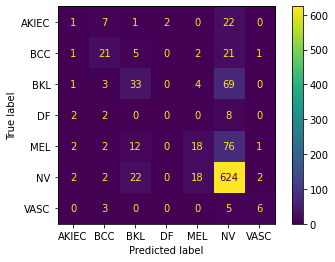

Here are the ROC Curves: 



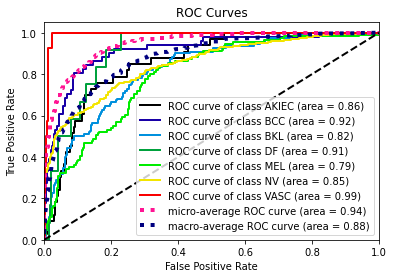

In [8]:
from sklearn.linear_model import LogisticRegression

"""
logreg_parameters = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20), 'solver' : ['saga'], 'class_weight' : ['balanced',None]}
clf = LogisticRegression(random_state=42)
logreg_clf = GridSearchCV(clf, logreg_parameters, scoring = 'neg_log_loss', n_jobs=-1)
logreg_clf.fit(X_train, y_train)
print(logreg_clf.best_params_)
logreg_clf = logreg_clf.best_estimator_
"""


logreg_clf = LogisticRegression(C = 0.615848211066026, penalty = 'l1', solver = 'saga', max_iter = 1000, random_state=42)
logreg_clf.fit(X_train, y_train)

evaluate_model(model = logreg_clf, y_test = y_test, X_test = X_test)

Hyperparameter tuning over {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20), 'solver' : ['saga'], 'class_weight' : ['balanced',None]} resulted in {C = 0.615848211066026, penalty = 'l1', solver = 'saga', max_iter = 1000, random_state=42}.. Seems to perform well compared to other methods so far.

# k-Nearest Neighbors

Model Accuracy is 72.63%
Log loss of the model is 2.107
Matthews Correlation Coefficient is 0.396

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.56      0.30      0.39        33
         BCC       0.53      0.33      0.41        51
         BKL       0.42      0.43      0.43       110
          DF       0.00      0.00      0.00        12
         MEL       0.31      0.05      0.08       111
          NV       0.79      0.97      0.87       670
        VASC       0.00      0.00      0.00        14

    accuracy                           0.73      1001
   macro avg       0.37      0.30      0.31      1001
weighted avg       0.65      0.73      0.67      1001

Confusion Matrix is here:



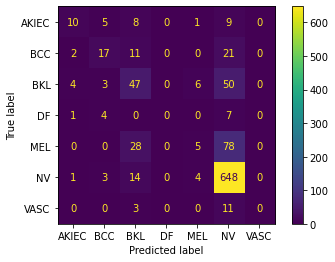

Here are the ROC Curves: 



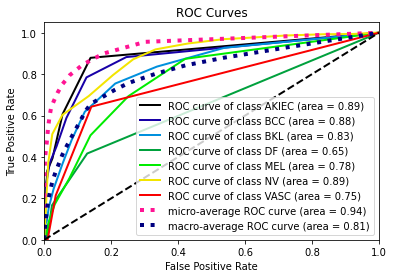

In [9]:
from sklearn.neighbors import KNeighborsClassifier

'''
knn_parameters = {'leaf_size': list(range(1,5)), 'n_neighbors': list(range(1,15)), 'p': [1,2]}
clf = KNeighborsClassifier()
knn_clf = GridSearchCV(clf, knn_parameters, scoring = 'neg_log_loss', n_jobs=-1)
knn_clf.fit(X_train, y_train)
print(knn_clf.best_params_)
knn_clf = knn_clf.best_estimator_
'''

knn_clf = KNeighborsClassifier(leaf_size=1, n_neighbors=14, p = 2)
knn_clf.fit(X_train, y_train)

evaluate_model(model = knn_clf, y_test = y_test, X_test = X_test)

Hyperparameter tuning of {'leaf_size': list(range(1,5)), 'n_neighbors': list(range(1,15)), 'p': [1,2]} lead to best params of {'leaf_size': 1, 'n_neighbors': 14, 'p': 2}. Model has pretty high log loss compared to others.

# Kernel Support Vector Machines

Model Accuracy is 75.42%
Log loss of the model is 0.676
Matthews Correlation Coefficient is 0.486

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.42      0.42      0.42        33
         BCC       0.51      0.51      0.51        51
         BKL       0.54      0.47      0.50       110
          DF       0.00      0.00      0.00        12
         MEL       0.57      0.23      0.33       111
          NV       0.82      0.94      0.88       670
        VASC       0.83      0.36      0.50        14

    accuracy                           0.75      1001
   macro avg       0.53      0.42      0.45      1001
weighted avg       0.72      0.75      0.73      1001

Confusion Matrix is here:



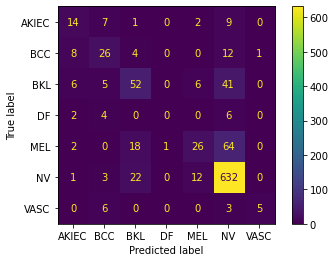

Here are the ROC Curves: 



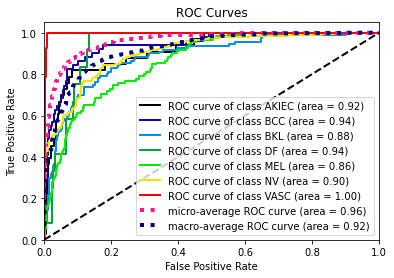

In [10]:
from sklearn.svm import SVC

'''
svm_parameters = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
clf = SVC(probability=True)
svm_clf = GridSearchCV(clf, svm_parameters, scoring = 'neg_log_loss', n_jobs=-1)
svm_clf.fit(X_train, y_train)
print(svm_clf.best_params_)
svm_clf = svm_clf.best_estimator_
'''

svm_clf = SVC(C = 10, gamma = 0.01, kernel='rbf', probability = True, random_state=42)
svm_clf.fit(X_train, y_train)

evaluate_model(model = svm_clf, y_test = y_test, X_test = X_test)

Hyperparameter tuning out of {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']} gave the optimal parameters of {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}. This seems to be the best performing model of all, across various metrics.

## Kernel Support Vector with original training dataset has had the highest performance on the validation set.